# Identifying Electric Vehicle Charging on Residential Power Grid

Chris Grace  
Updated September 2021


## Objective:

The city of Ipswich, MA uses electric meters which record usage patterns every hour in kilowatt hours (kWh).  Determine which residences are likely to be charging electric vehicles (EVs) based on usage patterns.  This data could be used to modify behavior through incentives to shift charging to off-peak times and reduce peak demand on the grid.

## Data:

- Initially 23 electric meters will be analyzed as a proof of concept.  This data could eventually be expanded to identify EVs for the approximately 7000 residential meters.
- The original 23 meters were chosen because some of them are known to have EVs.  Other houses in the list do not have confirmed EVs, but they have also not been confirmed to not have an EV.
- The desire is to make sure that most EV's are being captured (true positives).  This means we want a high sensitivity in our method.  If we have more false positives (Type I errors), this will allow false positives to later be filtered out by direct interaction with the customer or another analytical technique, rather than having the data ignored as part of the larger population of non EV vehicle owning households.  

- The data is in CSV files, where the file name is the meter number.  
    - Each CSV file has at minimum the following columns: 
        - "Reading Date"
        - "Consumption (kWh)"
    - Houses with solar panels will also have:
        - "Energy Received (kWh)"
    - Note: Meter IDs have been modified for this project to ensure anonymity.

## Methodology:

The following key indicators were selected as a good starting point to set search criteria based on research on EV charging and household energy use:

| Category |  Duration (hrs)  |  Energy (kWh/hr)  |  Season  |  Expected Time  |  Source (Energy Req.)|
| :-:      | :-:              | :-:               | :-:      | :-:             | :-:       |
| Electric Car (31 mi/day) | 1.5  | 5.7 | All | 5PM to 6AM | 1. |
|Air Conditioner, Central (3 ton)  | 6-24 | 3   |Summer|-| 2. |
|Clothes Dryer, Electric   | 1    | 2.3 | All | 6AM - 12PM | 3. |
|Electric Oven | 1 | 2.3 | All | 5-7 pm | 2. |
|Pool Pump (2092 W) | 6 | 2.1 | Summer | - | 4. |
|Electric Stove (Surface) | 1 | 1.25 | All | 6AM to 8PM | 2. |
|Air Conditioner, Window (8,000 Btu) | 6-24 | 0.7 | Summer | - | 2. |

    Sources:

1. https://www.nrc.gov/docs/ML1006/ML100621425.pdf  
At the national level the average commute is 15.3 miles each way (31 miles total)
2. https://www.siliconvalleypower.com/residents/save-energy/appliance-energy-use-chart
3. https://www.energystar.gov/sites/default/files/asset/document/ENERGY_STAR_Scoping_Report_Residential_Clothes_Dryers.pdf
4. https://www.nrel.gov/docs/fy12osti/54242.pdf

##### Search Criteria 1:  Count of usage which is 4.5 kWh higher than the average usage 2 hours prior and 2 hours after each record examined.
- This is likely to count a high power (24 amp, 5.7 kW) EV charger while ignoring things like electric stoves, ovens, and dryers.

Method:
- Most popular EVs get about 25 kWh/100 mi (source: https://www.fueleconomy.gov/) 
    - 25 kWh/100mi*31mi = 7.75 kWh per day
- At 89% efficiency (source: https://ieeexplore.ieee.org/document/7046253)
    - 8.7 kWh would be required  
    - For a 30 amp, 5.7 kWh charger, charging will take ~1.5 hrs
       


##### Search Criteria 2:  Count of usage which is at least 20 kWh over 5 hours.
- This will catch lower power chargers based on a large usage over a long duration.

##### Search Criteria 3:  Total-off peak usage (between 12am and 7am)
- This is intended to identity users with high overnight charging as a catch all for everything else when there is less noise in the data.  High ranking houses in this category which are not in the other two categories may be considered as potential EV houses.

##### Additional Comments
- Focus on 2019 rather than 2020: Due to pandemic, EVs may not charge regularly if owner is working from home.
- Ignore summer months: Air conditioning will affect results
- Ignore winter months: Electric heat and heat pumps may affect results

Therefore, data will summarize April, May, September, and October of 2019

It is expected that there will be:
- False positives caused by other high energy uses
- False negatives caused by short duration charging, an EV with a low-capacity battery (example plug in hybrids), using work or other chargers, or a low power charger that is used to top off a battery which doesn't see a lot of miles.
- As stated previously, the intent is to try to be more inclusive with the final summary since suspected EV houses can be confirmed once the filtered list of houses is generated.

## Load Required Modules

In [1]:
import pandas as pd
import numpy as np
import datetime  #allows dates to be manipulated
import os  #Miscellaneous operating system interfaces

#Machine Learning Modules

from sklearn import preprocessing
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

## Get List of File Names

In [2]:
#create list of file names
dir_name='Meter Data/' #reversed slashes to make path valid
filenamelist = os.listdir(dir_name) 
filenamelist

#merge file name and file path
pathlist=[]
for filename in filenamelist:
    pathlist.append(os.path.join(dir_name, filename))
    


## Function to Prevent Division by Zero

In [3]:
#Create function to prevent division by zero when finding average.
def safe_div(n,d):
    if d == 0:
        return 0
    return (n/d).round(1)


## Collect Data

#### Function: function_one_hour
- Compare each record to the average of 2 hours back and 2 hours forward.  Trigger if current record is 4.5 kWh greater than before and after average.

- Return:
    - Count of 1 hour triggers
    - Average value that caused trigger

In [2]:
def function_one_hour(df): 
    #Find average 2 hours backwards and 2 hours forwards and subtract that from current hour
    df['TriggerTest']=df["Consumption (kWh)"]-(df['Consumption (kWh)'].shift(2)+df['Consumption (kWh)'].shift(-2))/2
    
    #set value to 1 if value is over 4.5 else set value to 0
    df['One_Hour_Trigger']=df.apply(lambda x: 1 if x['TriggerTest'] >= 4.5 else 0, axis=1)
    
    #set value to 1 in "mask_one_hr" if current hour has a trigger and previous hour doesn't  
    mask_one_hr=((df['One_Hour_Trigger']-df['One_Hour_Trigger'].shift(1)) == 1)
    df=df.loc[mask_one_hr]
    
    #take average usage value using safe_div function to avoid dividing by zero
    trigger_avg=safe_div(df['TriggerTest'].sum(),df['TriggerTest'].count()) 
    
    #count number of triggers
    trigger_count=df['One_Hour_Trigger'].count() 
    
    return trigger_count, trigger_avg

#### Function: function_five_hour
- Find sections of data with a usage equal to or over 20 kW for 5 hours which is an average of at least 4kWh
- Return:
    - Count of 5 hour triggers 
    - Average value that caused the trigger

In [5]:
def function_five_hour(df):
    #Find average 1 and 2 hours backwards & 1 and 2 hours forwards and subtract that from current hour
    df['Five_Hour_Sum']=df["Consumption (kWh)"]+df['Consumption (kWh)'].shift(2)+df['Consumption (kWh)'].shift(1)+df['Consumption (kWh)'].shift(-1)+df['Consumption (kWh)'].shift(-2)
    
    #set value to 1 if value is over 20 else set value to 0
    df['Five_Hour_Trigger']=df.apply(lambda x: 1 if x['Five_Hour_Sum'] >= 20 else 0, axis=1)
    
    #set value to 1 in "mask_five_hr" if current hour has a trigger and previous hour doesn't
    mask_five_hr=((df['Five_Hour_Trigger']-df['Five_Hour_Trigger'].shift(1)) == 1)
    df=df.loc[mask_five_hr]
    
    #take average usage value using safe_div function to avoid dividing by zero
    five_hour_trigger_avg=safe_div(df['Five_Hour_Sum'].sum(),df['Five_Hour_Sum'].count())
    
    #count number of triggers
    five_hour_trigger_count=df['Five_Hour_Trigger'].count() 
    
    return five_hour_trigger_count, five_hour_trigger_avg

#### Function: function_night_usage

- Sum up usage data between 12AM and 6AM
- Find max peak usage between 12AM and 6AM

In [6]:
def function_night_usage(df):
    df=df.sort_values(by='Reading Date')
    df=df.set_index('Reading Date')  
    df=df.between_time('01:00', '06:00') #shifted forward an hour since data is recorded at the start of following hour
    
    #sum of off peak usage
    off_peak_usage=int((df['Consumption (kWh)']).sum())
    
    #max off peak usage
    off_peak_usage_max=int((df['Consumption (kWh)']).max())
    return off_peak_usage, off_peak_usage_max

#### Function: getvalues

- Determine if house has solar panels
- Filter by 2019
    - Collect usage summary for 2019
- Filter by April, May, September, and October
    - Collect usage summary for spring and fall
    - Collect 1hr and 5hr triggers
    - Collect off-peak summary data
- Append dataframe with all summary values for specific meter file being read

In [7]:
finallist=[]
dfworking=[]
j = 0

def getvalues(filename, year):
    global j
    dfworking=pd.read_csv(pathlist[j]) #read meter to be analyized
    j=j+1
    
    dfworking['Reading Date']=pd.to_datetime(dfworking['Reading Date']) #ensure "Reading Date" column is in date format
    meter = filename.replace('.csv', "", 1) #remove .csv suffix
    
    #Find houses with solar panels by looking for "Energy Received (kWh)" column
    if 'Energy Received (kWh)' in dfworking.columns: 
        if (dfworking['Energy Received (kWh)']).count() > 0:
            solar_panels = True
        else: solar_panels = False
    else: solar_panels = False
    
    #Create mask to filter by year
    maskinitial=((dfworking['Reading Date'] >= year+'-01-01 00:00:00') & (dfworking['Reading Date'] < str(int(year)+1)+'-01-01 00:00:00'))
    dfworking=dfworking.loc[maskinitial]     
    null_values_2019=int(dfworking['Consumption (kWh)'].isnull().sum())
    dfworking = dfworking.dropna()    
   
    #if dfworking has records
    if len(dfworking.index) > 0:    
       
        #Get max and min dates in 2019
        date_max=max(dfworking['Reading Date'])
        date_min=min(dfworking['Reading Date'])
        consumption_max_2019=int(dfworking["Consumption (kWh)"].max())

        #filter consumption over 50kWh so it data in error doesn't skew average
        maskhigh=dfworking['Consumption (kWh)'] <50
        dfworking=dfworking.loc[maskhigh]
        consumption_sum_2019=int(dfworking["Consumption (kWh)"].sum())

        #Mask to only include: Apr, May, Sep, Oct
        mask=(((dfworking['Reading Date'] >= year+'-04-01 00:00:00') & (dfworking['Reading Date'] < year+'-06-01 00:00:00')) |
        ((dfworking['Reading Date'] >= year+'-09-01 00:00:00') & (dfworking['Reading Date'] < year+'-11-01 00:00:00'))) #create mask by desired date range
        dfworking=dfworking.loc[mask]

        #if dfworking has records
        if len(dfworking.index) > 0:   
            
            #summarize data
            consumption_max=int(dfworking["Consumption (kWh)"].max())
            consumption_sum=int(dfworking["Consumption (kWh)"].sum())
            trigger_count, trigger_avg=function_one_hour(dfworking)
            five_hour_trigger_count, five_hour_trigger_avg=function_five_hour(dfworking)
            off_peak_usage, off_peak_usage_max =function_night_usage(dfworking) 
        else:
            # dfworking has no records
            consumption_max=0
            consumption_sum=0
            trigger_avg=0
            trigger_count=0
            five_hour_trigger_count=0
            five_hour_trigger_avg=0
            off_peak_usage=0
            off_peak_usage_max=0
    else:
        # dfworking has no records
        date_max=0
        date_min=0
        consumption_max_2019=0
        consumption_sum_2019=0
        consumption_max=0
        consumption_sum=0
        trigger_avg=0
        trigger_count=0
        five_hour_trigger_count=0
        five_hour_trigger_avg=0
        off_peak_usage=0
        off_peak_usage_max=0

    #print status of script
    print(j,' of ', len(filenamelist),'  |   Meter: ', meter, '|Solar: ', solar_panels,'|  1hr Trigger Count: ', trigger_count, '|  5hr Trigger Count: ', five_hour_trigger_count, '|  Consumption Sum: ', consumption_sum)
    
    #append summary of each file to "finallist"
    finallist.append([meter, solar_panels, trigger_count, trigger_avg, five_hour_trigger_count, five_hour_trigger_avg, off_peak_usage, off_peak_usage_max, consumption_max, consumption_sum, consumption_sum_2019, consumption_max_2019, null_values_2019, date_max, date_min])    
    
    return(finallist)



#### Loop through all data files available.  Use getvalues function to combine all summary data into a single dataframe.

In [8]:
#define year to be analyized
year='2019'

In [9]:
for i in filenamelist:
    getvalues(i, year)

#rename columns and write to new dataframe "dfsummary"
dfsummary=[]
dfsummary=pd.DataFrame(finallist, columns=["Meter Number", "Solar Panels?", "1hr Trigger Count", "1hr Trigger Average", '5hr Trigger Count', '5hr Trigger Avg', 'Offpeak Total (kwh)', 'Offpeak Max (kwh)', 'Consumption Max (kWh)', 'Consumption Sum (kWh)', 'Consumption Sum 2019 (kWh)','Consumption Max 2019 (kWh)', 'Missing Data 2019 (Hours)', 'Max Date 2019', 'Min Date 2019'])


1  of  23   |   Meter:  R02657 |Solar:  False |  1hr Trigger Count:  1 |  5hr Trigger Count:  0 |  Consumption Sum:  214
2  of  23   |   Meter:  R15467 |Solar:  False |  1hr Trigger Count:  2 |  5hr Trigger Count:  0 |  Consumption Sum:  1362
3  of  23   |   Meter:  R23573 |Solar:  False |  1hr Trigger Count:  0 |  5hr Trigger Count:  0 |  Consumption Sum:  213
4  of  23   |   Meter:  R24362 |Solar:  False |  1hr Trigger Count:  9 |  5hr Trigger Count:  10 |  Consumption Sum:  4008
5  of  23   |   Meter:  R27853 |Solar:  False |  1hr Trigger Count:  0 |  5hr Trigger Count:  0 |  Consumption Sum:  738
6  of  23   |   Meter:  R45234 |Solar:  False |  1hr Trigger Count:  0 |  5hr Trigger Count:  2 |  Consumption Sum:  3764
7  of  23   |   Meter:  R45544 |Solar:  True |  1hr Trigger Count:  9 |  5hr Trigger Count:  0 |  Consumption Sum:  1595
8  of  23   |   Meter:  R45645 |Solar:  False |  1hr Trigger Count:  0 |  5hr Trigger Count:  6 |  Consumption Sum:  4410
9  of  23   |   Meter:  R45

#### Sort final dataframe and write to CSV file.

In [10]:
#Sort data
dfsummary=dfsummary.sort_values(by=['1hr Trigger Count','5hr Trigger Count','Offpeak Total (kwh)'], ascending=False)
dfsummary=dfsummary.set_index('Meter Number')
display(dfsummary)

#write data to CSV file
dfsummary.to_csv('FinalSummary'+year+'.csv')

,Solar Panels?,1hr Trigger Count,1hr Trigger Average,5hr Trigger Count,5hr Trigger Avg,Offpeak Total (kwh),Offpeak Max (kwh),Consumption Max (kWh),Consumption Sum (kWh),Consumption Sum 2019 (kWh),Consumption Max 2019 (kWh),Missing Data 2019 (Hours),Max Date 2019,Min Date 2019
Meter Number,,,,,,,,,,,,,,
R45822,False,66,4.7,75,21.1,1676,8,11,6261,27314,14,27,2019-12-31 23:00:00,2019-01-01 00:00:00
R58678,True,63,6.3,9,21.2,738,8,9,3038,9070,8668,44,2019-12-31 23:00:00,2019-01-01 00:00:00
R47564,True,26,5.9,21,23.2,590,9,13,2805,9970,13,27,2019-12-31 23:00:00,2019-01-01 00:00:00
R24362,False,9,4.9,10,20.9,579,4,8,4008,13864,9,35,2019-12-31 23:00:00,2019-01-01 00:00:00
R45544,True,9,6.1,0,0.0,515,4,9,1595,11768,15,59,2019-12-31 23:00:00,2019-01-01 00:00:00
R85461,True,7,4.7,6,21.0,978,6,7,3459,15725,375,0,2019-12-31 23:00:00,2019-01-01 00:00:00
R73486,False,5,4.8,1,20.0,331,3,7,2401,9109,8,0,2019-12-31 23:00:00,2019-01-01 00:00:00
R48911,True,2,6.2,1,27.0,500,9,9,1516,6075,9,22,2019-06-06 23:00:00,2019-01-01 00:00:00
R75310,False,2,4.5,1,20.0,398,1,6,1854,7506,9,0,2019-12-31 23:00:00,2019-01-01 00:00:00


### Conclusions

After summarizing and reviewing data as well as adding in the known EVs, the data was color coded by an apparent drop off in the number of triggers.  While this part is open to interpretation, the idea was to look for a clear drop-off which could be adjusted, if necessary, to control how many false positives were acceptable.
The initial criteria are:
- 6x or higher 1 hour triggers
- 6x or higher 5 hour triggers
- 500 kWh total usage & at least 4 kWh Max Peak during off-peak hours

If a house has at least 2 of the above criteria it is consider a high probability EV house.
If it only has 1 of the criteria it is considered a medium probability EV house.

#### Below is the summary table after manipulating in Excel to add extra information and to color code
<img src="Town Data Final Summary.png" />

Based on the above criteria the final tally is below.  Keep in mind that the criteria could be adjusted.  This is just a manual grouping to get an idea of how the data could be grouped to automate the analysis of the summarized data.  The idea is there is likely always going to be some false positives and false negatives, but the criteria must be selected to minimize them.

- 12 houses were categorized as to not have an EV
- 5 houses were categorized to have an EV and have a confirmed EV.
- 4 houses were false positives, however upon visual inspection all 4 of them had some EV charging qualities, so they are considered good false positives to include in the count since they may turn out to have EVs.
- 2 houses with false negatives, however upon visual inspection both of these did not show EV charging qualities.  These owners may have an EV with a small battery or utilize off site charging.

Future improvements:
- Have a larger dataset of confirmed houses with and without EVs.  Where not all the houses had this information confirmed, it was difficult to make rules based on assumptions.
- Introduce machine learning to group the data in a more optimal way that does not rely on a user to make judgement calls.





### Machine Learning Addendum
#### K Means Clustering (Unsupervised Learning)

In [14]:
#define year to be analyized
year='2019'

#Read summary table which allows allows continuation without reading each individual file.
dfsummary=pd.read_csv('FinalSummary'+year+'.csv',index_col=0)

dfsummary.head()

,Solar Panels?,1hr Trigger Count,1hr Trigger Average,5hr Trigger Count,5hr Trigger Avg,Offpeak Total (kwh),Offpeak Max (kwh),Consumption Max (kWh),Consumption Sum (kWh),Consumption Sum 2019 (kWh),Consumption Max 2019 (kWh),Missing Data 2019 (Hours),Max Date 2019,Min Date 2019
Meter Number,,,,,,,,,,,,,,
R45822,False,66,4.7,75,21.1,1676,8,11,6261,27314,14,27,2019-12-31 23:00:00,2019-01-01 00:00:00
R58678,True,63,6.3,9,21.2,738,8,9,3038,9070,8668,44,2019-12-31 23:00:00,2019-01-01 00:00:00
R47564,True,26,5.9,21,23.2,590,9,13,2805,9970,13,27,2019-12-31 23:00:00,2019-01-01 00:00:00
R24362,False,9,4.9,10,20.9,579,4,8,4008,13864,9,35,2019-12-31 23:00:00,2019-01-01 00:00:00
R45544,True,9,6.1,0,0.0,515,4,9,1595,11768,15,59,2019-12-31 23:00:00,2019-01-01 00:00:00


Reduce the table to just the categories we want to use for kmeans

In [85]:
df_grouping=dfsummary[['Solar Panels?', '1hr Trigger Count', '5hr Trigger Count', 'Offpeak Total (kwh)', 'Offpeak Max (kwh)']]
X=df_grouping
X.head()

,Solar Panels?,1hr Trigger Count,5hr Trigger Count,Offpeak Total (kwh),Offpeak Max (kwh)
Meter Number,,,,,
R45822,False,66,75,1676,8
R58678,True,63,9,738,8
R47564,True,26,21,590,9
R24362,False,9,10,579,4
R45544,True,9,0,515,4


Normalize the Data

In [239]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.59408853,  3.16175263,  4.41775252,  3.08171665,  1.68875153],
       [ 1.68325082,  2.99722704,  0.17603947,  0.58753316,  1.68875153],
       [ 1.68325082,  0.9680781 ,  0.94726003,  0.19399462,  2.06585138],
       [-0.59408853,  0.03576643,  0.24030785,  0.16474513,  0.1803521 ],
       [ 1.68325082,  0.03576643, -0.40237594, -0.0054337 ,  0.1803521 ]])

Create numpy array with customers known to have EVs

In [240]:
ev_answers=['NO', 'EV', 'EV', 'NO', 'EV', 'NO', 'NO', 'EV', 'NO', 'NO', 'NO', 'EV', 'NO', 'NO', 'NO', 'EV', 'EV', 'NO', 'NO', 'NO', 'NO', 'NO', 'NO']
y = pd.DataFrame({'EV?': ev_answers}).to_numpy().ravel() # convert to 1D numpy array
y[0:5]

array(['NO', 'EV', 'EV', 'NO', 'EV'], dtype=object)

Use elbow method to explore values for K.

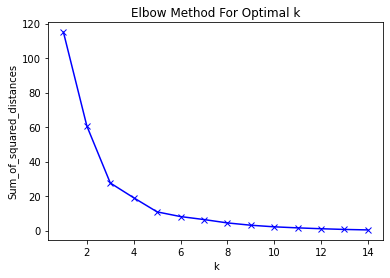

In [88]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Values from 3 and 5 seem of most interest.  Let's use 4.
Create 4 clusters and create labels

In [243]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[2 1 1 3 1 1 3 1 0 0 0 1 3 3 3 3 3 3 3 0 0 0 0]


Assign cluster labels to df_grouping

In [282]:
df_grouping_clusters=df_grouping
df_grouping_clusters.loc[:,"Clusters"] = labels
df_grouping_clusters.loc[:,"EV?"] = ev_answers
df_grouping_clusters.loc[:,'EV?'] = df_grouping_clusters['EV?'].map({'EV': 1, 'NO': 0})
df_grouping_clusters

,Solar Panels?,1hr Trigger Count,5hr Trigger Count,Offpeak Total (kwh),Offpeak Max (kwh),Clusters,EV?
Meter Number,,,,,,,
R45822,False,66,75,1676,8,2,0
R58678,True,63,9,738,8,1,1
R47564,True,26,21,590,9,1,1
R24362,False,9,10,579,4,3,0
R45544,True,9,0,515,4,1,1
R85461,True,7,6,978,6,1,0
R73486,False,5,1,331,3,3,0
R48911,True,2,1,500,9,1,1
R75310,False,2,1,398,1,0,0


In [283]:
print('Group by Cluster Number and Average Columns')
display(df_grouping_clusters.groupby('Clusters').mean())
group_summary=df_grouping_clusters.groupby('Clusters').agg({'EV?': ['sum', 'count']})
print('Group by Cluster Number and Sum EVs to compare against total count')
display(group_summary)




Group by Cluster Number and Average Columns


,Solar Panels?,1hr Trigger Count,5hr Trigger Count,Offpeak Total (kwh),Offpeak Max (kwh),EV?
Clusters,,,,,,
0,False,0.714286,0.142857,115.714286,1.142857,0.000000
1,True,17.833333,8.166667,631.666667,6.833333,0.833333
2,False,66.000000,75.000000,1676.000000,8.000000,0.000000
3,False,1.555556,2.111111,624.000000,2.666667,0.222222


Group by Cluster Number and Sum EVs to compare against total count


EV?      
         sum count
Clusters          
0          0     7
1          5     6
2          0     1
3          2     9

The data shows that cluster 1 contains most of the EVs with 5 out of 6 (83%).  The only meter which is incorrectly classified is meter R85461, but it does seem to fit the group based on the summary results.

Cluster 2 and 3 correctly show no EVs.  However, if just looking at the summary you'd be tempted to put the single car in cluster 2 in the EV category since it has the most triggers.

Cluster 0 shows 2 EVs out of 9 customers (22%).  Upon looking at the summary data these were two cars which have seemed to be outliers in the data.  Meter R48976 is a BMW EV which has a small battery, so it may not show up in the electric usage data and meter R47897 could not be confirmed to have an EV, but was believed to be a Volt.

Overall this method of K Means Grouping seems to have provided a reasonable result and could provide a good result when scaling to larger datasets.

### Let's repeat the process with K Nearest Neighbor

In [289]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn import metrics
from sklearn.model_selection import cross_val_score

Define Learn and Test Set  
This data set is probably a bit small, but lets explore to see what results we get.

In [220]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (18, 5) (18,)
Test set: (5, 5) (5,)


Determine Best K value

In [287]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.4, 0.4, 0.6, 0.4, 0.8, 0.8, 0.8, 0.8, 0.8])

Plot all K values

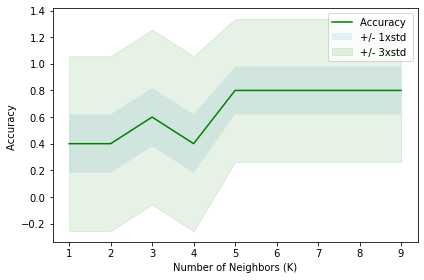

The best accuracy was with 0.8 with k= 5


In [288]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

Since the dataset is small lets use cross validation to use all the data.

Create KNN model.  From the previous test with the limited dataset, lets define the k value (n_neighbors at 5).

In [291]:
knn_cv = KNeighborsClassifier(n_neighbors=5)
knn_cv


KNeighborsClassifier()

Using cross validation, lets break the data up into 5 sets.

In [298]:
cv_scores = cross_val_score(knn_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print('Score for each of the 5 sets: ',cv_scores)
print('cv_scores mean: ', np.mean(cv_scores))

Score for each of the 5 sets:  [0.8  0.8  0.8  0.75 0.75]
cv_scores mean:  0.78


Overall, the K Nearest Neighbor method produced an average of 78% accuracy.
Future recommendations:
- Increase the training and test size
- Get further confirmation on if the meters which don't show an EV truely do not have one.
- Deploy method onto full dataset of 7000 meters.